1. Modele o espectro de uma galáxia observada no redshift 1 com modelo de poeira, emissão nebular e double power law

In [1]:
import numpy as np
import bagpipes as pipes
import matplotlib.pyplot as plt

dblplaw = {}
dblplaw["tau"] = 5.
dblplaw["alpha"] = 2.5
dblplaw["beta"] = 10.
dblplaw["massformed"] = 10.
dblplaw["metallicity"] = 0.5

dust = {}                         
dust["type"] = "Calzetti"         
dust["Av"] = 0.2                  
dust["eta"] = 3.

nebular = {}
nebular["logU"] = -2.

model_components = {}
model_components["redshift"] = 1.0
model_components["dblplaw"] = dblplaw
model_components["dust"] = dust
model_components["veldisp"] = 200. 
model_components["nebular"] = nebular

model = pipes.model_galaxy(model_components, spec_wavs=np.arange(5000., 10000., 5.))

sfh = model.sfh.plot()
fig = model.plot()

Bagpipes: PyMultiNest import failed, fitting will use the Nautilus sampler instead.


2. Ajuste o espectro fotométrico de uma galáxia do catálogo VANDELS utilizando bagpipes para obter os valores de redshift observado, dispersão de velocidades e metalicidade.

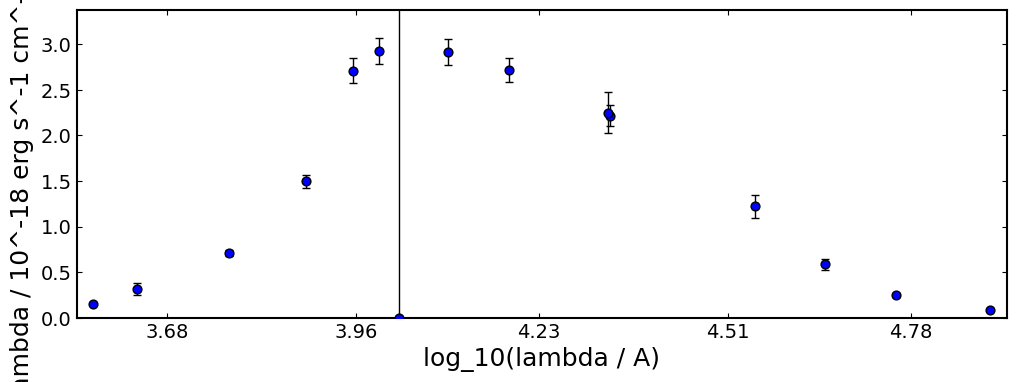

MultiNest not available. Switching to nautilus.

Bagpipes: fitting object 017433


Completed in 258.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dblplaw:age                    2.284      8.049     12.700
dblplaw:alpha                 28.090     50.195     84.781
dblplaw:beta                  24.740     49.266     80.129
dblplaw:massformed            10.994     11.034     11.079
dblplaw:metallicity            0.584      1.031      1.507
dblplaw:tau                    4.031      4.308      4.523
dust:Av                        0.389      0.520      0.657
redshift                       1.015      1.058      1.095




c:\Users\redbr\AppData\Local\Programs\Python\Python311\Lib\site-packages\bagpipes\models\star_formation_history.py:278: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1


In [6]:
from astropy.io import fits

def load_goodss(ID):
    """ Load UltraVISTA photometry from catalogue. """

    # load up the relevant columns from the catalogue.
    cat = np.loadtxt("hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
                     usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
                              11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
    # Find the correct row for the object we want.
    row = int(ID) - 1

    # Extract the object we want from the catalogue.
    fluxes = cat[row, :15]
    fluxerrs = cat[row, 15:]

    # Turn these into a 2D array.
    photometry = np.c_[fluxes, fluxerrs]

    # blow up the errors associated with any missing fluxes.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**99.]
            
    # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
    for i in range(len(photometry)):
        if i < 10:
            max_snr = 20.
            
        else:
            max_snr = 10.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr

    return photometry



goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str")

galaxy = pipes.galaxy("017433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list)
fig = galaxy.plot()

dpl = {}
dpl["age"] = (0.1, 15.)

dpl["tau"] = (0.3, 10.)
dpl["massformed"] = (1., 15.)
dpl["metallicity"] = (0., 2.5)
dpl["alpha"] = (0, 100)
dpl["beta"] = (0, 100)


dust = {}
dust["type"] = "Calzetti"
dust["Av"] = (0., 2.)

fit_instructions = {}
fit_instructions["redshift"] = (0., 10.)
fit_instructions["dblplaw"] = dpl
fit_instructions["dust"] = dust

fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)

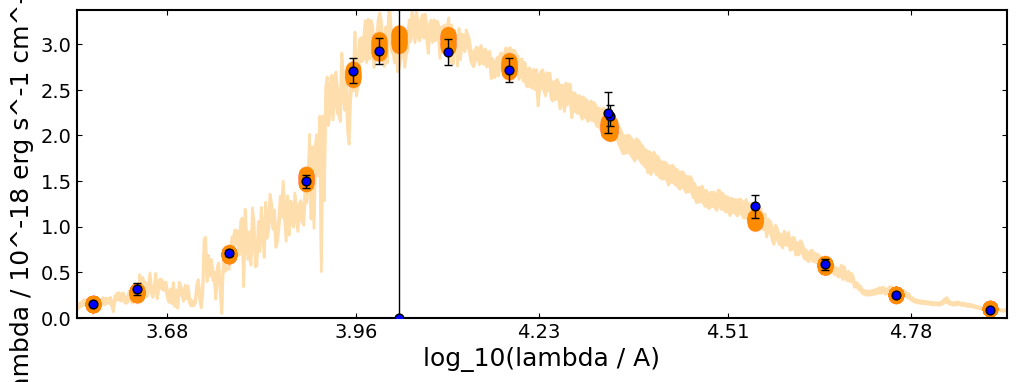

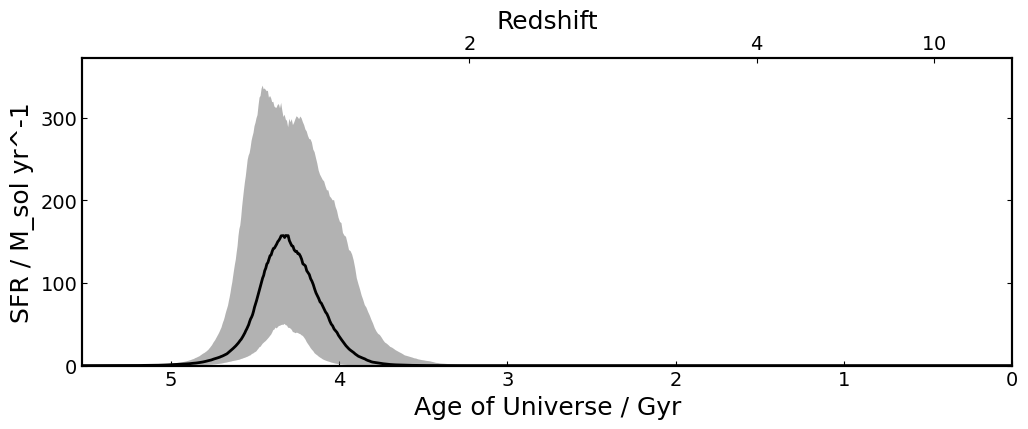

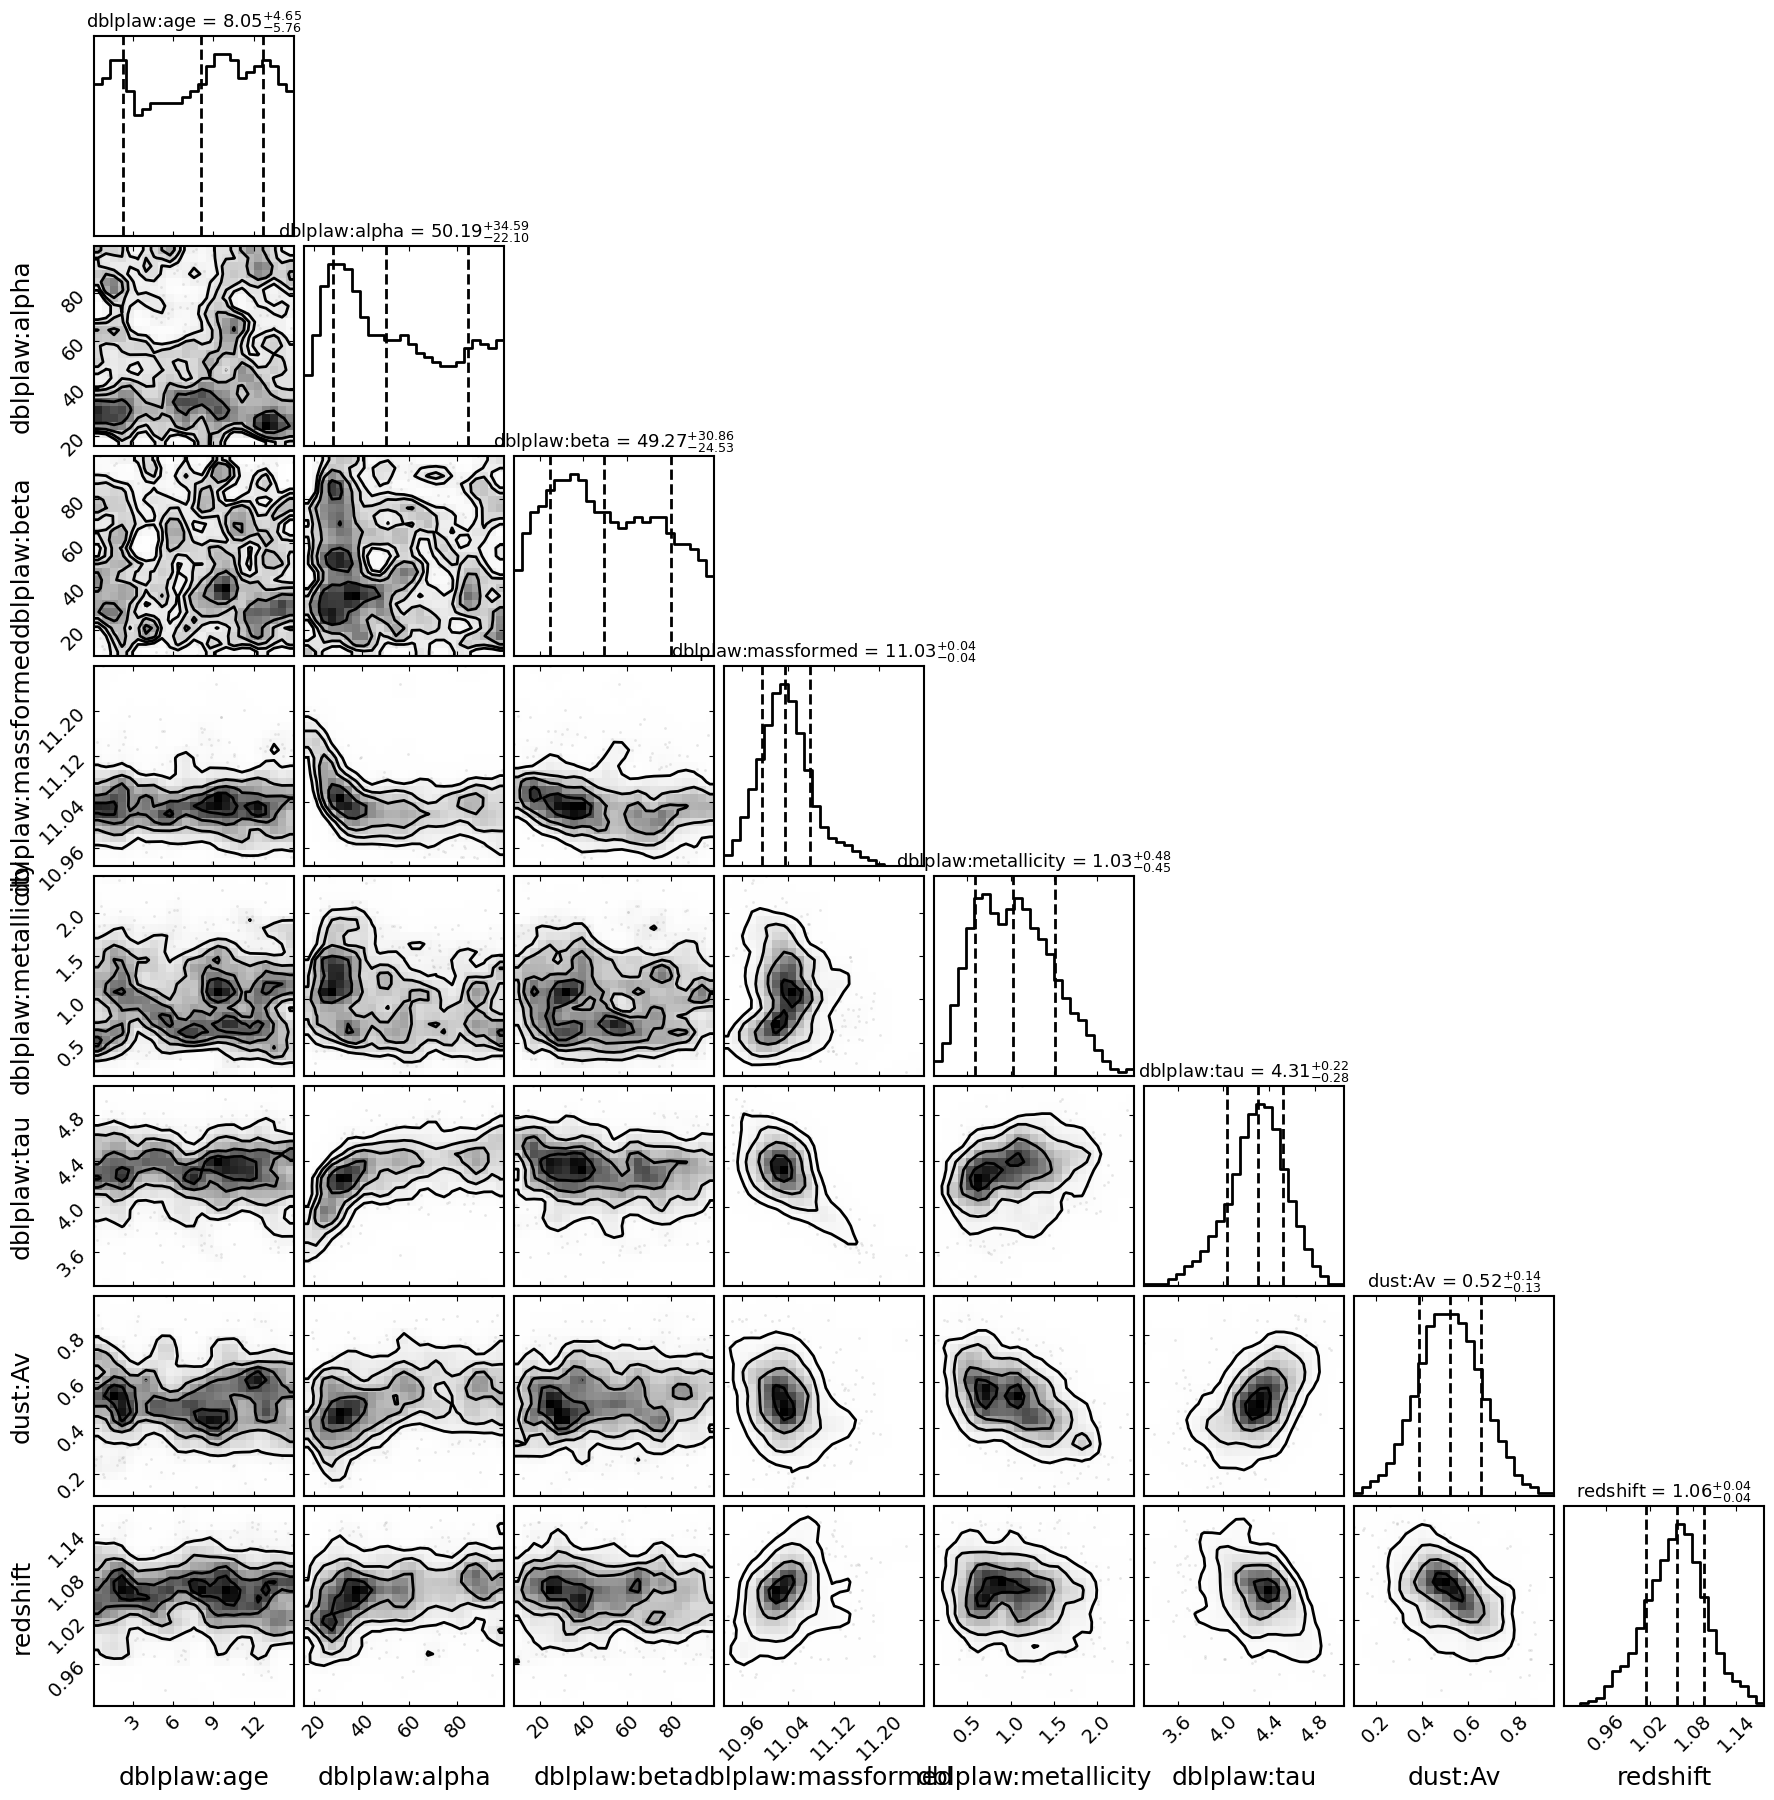

In [7]:
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)

2. Ajuste o espectro (dados espectrais) de uma galáxia do catálogo VANDELS utilizando bagpipes para obter os valores de redshift observado, dispersão de velocidades e metalicidade.

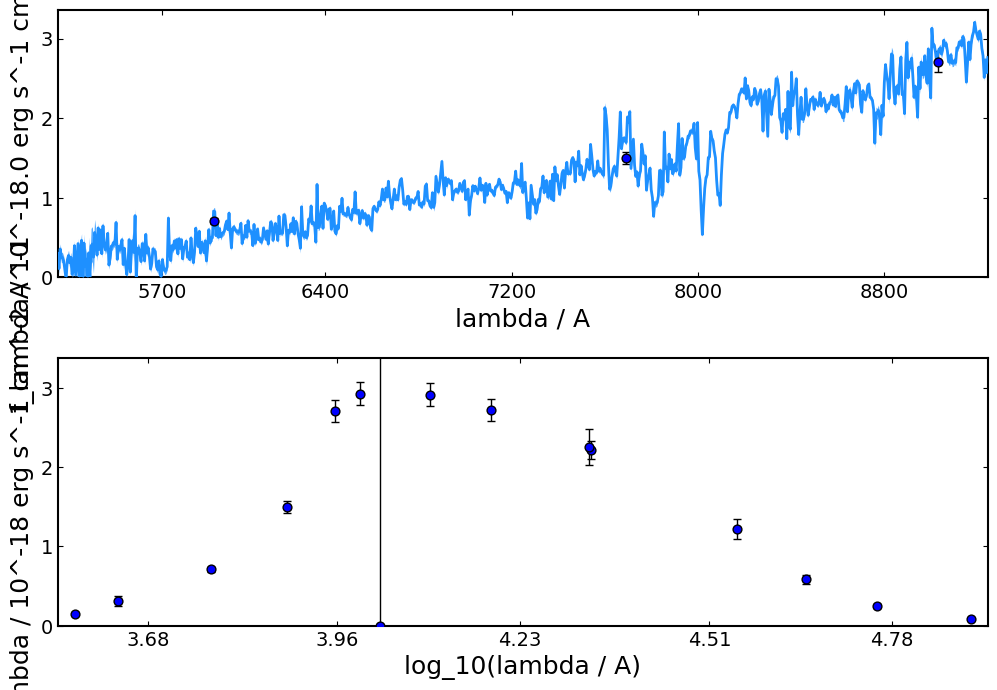


Results loaded from pipes/posterior/./017433.h5

Fitting not performed as results have already been loaded from pipes/posterior/./017433.h5. To start over delete this file or change run.



In [8]:
def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum) // binn
    binspec = np.zeros((nbins, spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec


def load_vandels_spec(ID):
    """ Loads VANDELS spectroscopic data from file. """

    hdulist = fits.open("VANDELS_CDFS_" + ID + ".fits")

    spectrum = np.c_[hdulist[1].data["WAVE"][0],
                     hdulist[1].data["FLUX"][0],
                     hdulist[1].data["ERR"][0]]

    mask = (spectrum[:,0] < 9250.) & (spectrum[:,0] > 5250.)

    return bin(spectrum[mask], 2)


def load_both(ID):
    spectrum = load_vandels_spec(ID)
    phot = load_goodss(ID)

    return spectrum, phot


goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str")

galaxy = pipes.galaxy("017433", load_both, filt_list=goodss_filt_list)

fig = galaxy.plot()

dpl = {}
dpl["age"] = (0.1, 15.)

dpl["tau"] = (0.3, 10.)
dpl["massformed"] = (1., 15.)
dpl["metallicity"] = (0., 2.5)
dpl["alpha"] = (0, 100)
dpl["beta"] = (0, 100)


dust = {}
dust["type"] = "Calzetti"
dust["Av"] = (0., 2.)

fit_instructions = {}
fit_instructions["redshift"] = (0., 10.)
fit_instructions["dblplaw"] = dpl
fit_instructions["dust"] = dust

fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)